# Training a Classifier (CIFAR10)

## Imports

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

## Data Loading

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

The transform process also:
1. Converts PIL image or NumPy array into PyTorch tensor.
2. Changes data layout from (H, W, C) for PIL/NumPy to (C, H, W) for PyTorch.

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] # mean, SD for each of the 3 channels
)

batch_size = 4

trainset = datasets.CIFAR10(root='./data', train=True, 
                            download=True, transform=transform) # download training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, num_workers=2) # load in dataset: random shuffle sample order at beginning of each epoch, num_workers for multiprocessing

testset = datasets.CIFAR10(root='./data', train=False, 
                            download=True, transform=transform) # download test dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # define class names

Files already downloaded and verified
Files already downloaded and verified


Show some training samples:

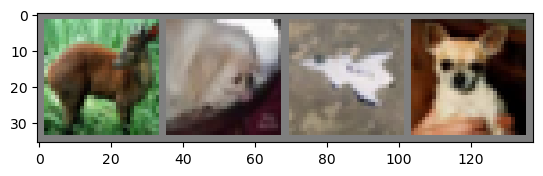

deer  dog   plane dog  


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # unnormalize (normalization is minus mean divide SD, so this is reverse process)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # matplotlib expects (H, W, C) not (C, H, W)
    plt.show()
    
# Get some training images
dataiter = iter(trainloader) # create iterator from DataLoader object trainloader to allow for stepping through by batch
images, labels = next(dataiter) # fetches next available mini-batch from trainloader

# Show images
imshow(torchvision.utils.make_grid(images)) # utility function to make single grid image from batch of images

# Print labels
print(' '.join(f"{classes[labels[j]]:5s}" for j in range(batch_size))) # labels[j] gets numeric label, classes[] gets human-readable name, :5 for 5-character-wide alignment

## Network Definition

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # Call parent class' constructor
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1) # flatten everything except first dimension which is batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        
        return output

net = Net()
        

## Define Loss Function and Optimizer

In [13]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

## Train the Network

Loop over data iterator, feed inputs to network and optimize

In [14]:
for epoch in range (2): # 2 epochs
    
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0): # for each mini-batch
        
        # Unpack data which is a list of [inputs, labels]
        inputs, labels =  data 
        
        # Zero gradient buffers of model parameters because autograd accumulates them
        optimizer.zero_grad() # can also call net.zero_grad() but less preferable
        
        # forward pass ->  calculate loss -> backward pass -> optimize
        outputs = net(inputs) # get predictions via forward pass
        loss = criterion(outputs, labels)
        loss.backward() # backward pass and populate .grad attributes
        optimizer.step() # optimizer update weights in-place by accessing stored .grad attributes
        
        # Print Statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0 # reset running_loss after 2000 mini-batches
            
print('Finished Training!')

[1,  2000] loss: 2.183
[1,  4000] loss: 1.826
[1,  6000] loss: 1.678
[1,  8000] loss: 1.572
[1, 10000] loss: 1.499
[1, 12000] loss: 1.470
[2,  2000] loss: 1.414
[2,  4000] loss: 1.374
[2,  6000] loss: 1.348
[2,  8000] loss: 1.321
[2, 10000] loss: 1.287
[2, 12000] loss: 1.274
Finished Training!


## Save the Model

More information about saving models: https://docs.pytorch.org/docs/stable/notes/serialization.html

In [15]:
PATH = './cifar_net_pth'
torch.save(net.state_dict(), PATH)

## Test Network on Test Data (Inference)

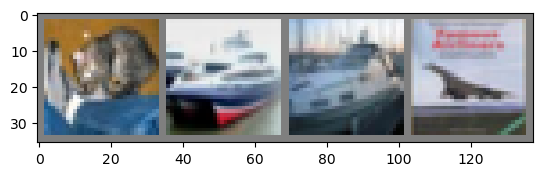

Ground Truth:  cat   ship  ship  plane


In [17]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# Print Images
imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Note that these 4 samples are same as PyTorch docs because no shuffle for test set

Reload model (unnecessary but for illustration purposes):

**Use weights_only=True for safer loading, especially from untrusted sources, as it prevents execution of potentially malicious code serialized with the model.**

In [18]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [ ]:
outputs = net(images) # obtain predictions with forward pass, shape is (batch_size, num_classes)

print(outputs) # predicted energies of each class for the 4 test images (higher means model thinks image is of particular class)

tensor([[-0.8416, -2.0160,  0.7194,  2.1654, -0.3780,  1.0238,  1.2822, -0.8990,
          0.1406, -1.4867],
        [ 4.4724,  6.3853, -2.7062, -2.6345, -2.6949, -4.2033, -3.3356, -4.5929,
          6.4995,  2.9371],
        [ 2.2460,  0.2424,  0.3827, -0.3642, -0.4857, -1.2474, -1.9317, -1.2040,
          1.7007,  0.4872],
        [ 3.5394,  1.7560, -0.2373, -1.0651, -1.3581, -2.7691, -2.3125, -2.6995,
          4.3088,  0.5557]], grad_fn=<AddmmBackward0>)


In [ ]:
# Get max score for each row; REMEMBER dim=1 is like obtaining a column vector
_, predicted = torch.max(outputs, dim=1) # torch.max returns 2 tensors: 1 containing max values, 1 containing indices of those max values
print('Max values: ', _)
print('Predicted indices: ', predicted)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' # refer back to the original classes definition list. predicted[j] gives index of max value for that row (image)
                              for j in range(4)))

Max values:  tensor([2.1654, 6.4995, 2.2460, 4.3088], grad_fn=<MaxBackward0>)
Predicted indices:  tensor([3, 8, 0, 8])
Predicted:  cat   ship  plane ship 


Now test on whole dataset instead of just that 4 images from a single mini-batch:

In [26]:
correct = 0 # Initialize counter for correctly predicted samples
total = 0   # Initialize counter for total samples processed

# Disable gradient calculation for inference (saves memory and computation)
with torch.no_grad():
    # Iterate over each mini-batch in the test dataset
    for data in testloader:
        images, labels = data # Unpack images and their true labels from the batch

        # Perform a forward pass to get model predictions (logits/energies)
        outputs = net(images)

        # Get the predicted class: find the index of the highest logit for each sample
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0) # Add the number of samples in the current batch to total count; size(0) is batch_size
        correct += (predicted == labels).sum().item() # Count correct predictions and add to total correct; true is treated as 1; .item converts single-element tensor to standard integer

# Calculate and print the final accuracy percentage
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 55 %


Check class-specific performance:

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes} # initialize correct dict with classname->0 pairs
total_pred = {classname: 0 for classname in classes} # initialize total pred dict with classname->0 pairs

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data # REMEMBER labels is in form of indices NOT string
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 57.7 %
Accuracy for class: car   is 69.3 %
Accuracy for class: bird  is 48.8 %
Accuracy for class: cat   is 26.7 %
Accuracy for class: deer  is 51.8 %
Accuracy for class: dog   is 49.5 %
Accuracy for class: frog  is 62.8 %
Accuracy for class: horse is 68.0 %
Accuracy for class: ship  is 61.0 %
Accuracy for class: truck is 59.5 %


## Training on GPU (not enabled in this example)

**Must initialize GPU device and send model and data (inputs and labels) to it if using**

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Send model to GPU

In [29]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Send data to GPU also (both inputs and labels)

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)